In [1]:
import pandas
import os
import numpy as np
import datetime
import time
import tqdm

In [2]:
def parse_datetime(datetime_string):
    result  = datetime_string.split('T')
    if len(result) < 2:
        return None
    date, time = datetime_string.split('T')
    year, month, day = [int(value) for value in date.split('-')]
    #print(year, month, day)
    hour, minute, second = [int(value) for value in time.split(':')]
    #print(hour, minute, second)
    datetime_object = datetime.datetime(year = year, month = month, day = day,\
                                        hour = hour, minute = minute, second = second)
    #print(datetime_object)
    return datetime_object.timestamp()

def add_timestamps(data):
    times_string = data['T'].as_matrix()
    timestamps = [int(parse_datetime(value)) for value in times_string]
    data['timestamp'] = pandas.Series(timestamps, index = data.index)
    return data

def add_missing(data, delta, boards = None):
    timestamps = data['timestamp'].as_matrix()
    min_timestamp = np.min(timestamps)
    max_timestamp = np.max(timestamps)
    
    if boards is None:
        start, end = min_timestamp, max_timestamp
    else:
        start, end = boards
    all_rows = []
    for value_now in range(start, end, delta):
        if value_now not in timestamps:
            nan_columns = [column for column in data.columns if column != 'timestamp']
            new_row = {}
            for column in nan_columns:
                new_row[column] = ''

            new_row['timestamp'] = value_now
            #data.append(new_row, ignore_index = 'True')
            all_rows.append(new_row)
    
    if len(all_rows) > 0:
        data = data.append(all_rows, ignore_index = 'True')
    data = data.sort_values(by = 'timestamp')
    return data



In [3]:
def read_datas(datas_type, delta, process = False):
    all_pairs = os.listdir('history')
    btc_pairs = [pair for pair in all_pairs if pair[0:3] == 'BTC']
    
    datas = {}
    print("reading ", datas_type)
    for btc_pair in tqdm.tqdm(btc_pairs):
        path = 'history/' + btc_pair +  '/' + datas_type + '/'
        file = None
        for it_file in os.listdir(path):
            if it_file[0] != '.':
                file = it_file 
       
        if process:
            datas[btc_pair] = add_missing(add_timestamps(pandas.read_csv(path + file, sep = ';')), delta)
        else:
            datas[btc_pair] = pandas.read_csv(path + file, sep = ';')
        
    return datas

In [4]:
def get_duration_info(datas):
    min_start, min_end, max_start, max_end = None, None, None, None
    min_duration, max_duration = None, None
    
    def update_max(new_value, max_now):
        
        if max_now is None:
            return new_value
        if new_value > max_now:
            return new_value
        return max_now
    
    def update_min(new_value, min_now):
       
        if min_now is None:
            return new_value
        if new_value < min_now:
            return new_value
        return min_now
    
    for key in datas.keys():
        this_start = parse_datetime(datas[key]['T'].iloc[0])
        this_end = parse_datetime(datas[key]['T'].iloc[-1])
        
        min_start = update_min(this_start, min_start)
        max_start = update_max(this_start, max_start)
        
        min_end = update_min(this_end, min_end)
        max_end = update_max(this_end, max_end)
        
       
            
        this_duration = this_end - this_start
        
        min_duration = update_min(this_duration, min_duration)
        max_duration = update_max(this_duration, max_duration)
        
    return datetime.datetime.fromtimestamp(min_start),\
           datetime.datetime.fromtimestamp(max_start),\
           datetime.datetime.fromtimestamp(min_end),\
           datetime.datetime.fromtimestamp(max_end),\
           min_duration,\
           max_duration
           

In [5]:
import tqdm
def get_intersections(segments):
    all_points_positions = []
    for segment in segments:
        all_points_positions.append(segment[0])
        all_points_positions.append(segment[1])
        
    all_points_positions = np.sort(all_points_positions)
    
    result = np.zeros([len(segments) + 1])
    solutions = [[]] * (len(segments) + 1)
    
    for left_index in range(all_points_positions.shape[0]):
        for right_index in range(left_index + 1, all_points_positions.shape[0]):
            left_board = all_points_positions[left_index]
            right_board = all_points_positions[right_index]
            length_now = right_board - left_board
            
            num_now = 0
            solution_now = []
            for i in range(len(segments)):
                segment = segments[i]
                if segment[0] <= left_board and segment[1] >= right_board:
                    num_now += 1
                    solution_now.append(i)
                
            
            if length_now > result[num_now]:
                result[num_now] = length_now
                solutions[num_now] = solution_now
    
    now = 0
    solution_now = []
    for i in range(len(segments), -1, -1):
        if result[i] > now:
            now = result[i]
            solution_now = solutions[i]
        if now > result[i]:
            result[i] = now
            solutions[i] = solution_now
        result[i] = max(now, result[i])
    
    return result[1:], solutions[1:]

In [6]:
def get_intersections_from_datas(datas):
    segments = []
    ordered_keys = list(datas.keys())
    for key in ordered_keys:
        this_start = parse_datetime(datas[key]['T'].iloc[0])
        this_end = parse_datetime(datas[key]['T'].iloc[-1])
        segments.append([this_start, this_end])
    
    intersections_info, solutions = get_intersections(segments)
    named_solutions = []
    for solution_now in solutions:
        named_solution_now = []
        for segment_id in solution_now:
            segment_name = ordered_keys[segment_id]
            named_solution_now.append(segment_name)
        named_solutions.append(named_solution_now)
        
    return intersections_info, named_solutions

In [7]:
from matplotlib import pyplot as plt

def convert_to_all(seconds):
    minutes = seconds / 60.0
    hours = minutes / 60.0
    days = hours / 24.0
    return days, hours, minutes

def get_full_summary():
    datas_types = ['oneMin', 'fiveMin', 'thirtyMin', 'hour', 'day']
    deltas = [60, 5 * 60, 30 * 60, 60 * 60, 60 * 60 * 24]
    intersections_summary = {}
    for i in range(len(datas_types)):
        datas_type = datas_types[i]
        delta = deltas[i]
        
        datas = read_datas(datas_type, delta)
        
        print("SUMMARY FOR " + datas_type + ":")
        min_start, max_start, min_end, max_end, min_duration, max_duration =\
                    get_duration_info(datas)
        print("min start: ", min_start)
        print("max start: ", max_start)
        print("min end: ", min_end)
        print("max end: ", max_end)
        
        min_start = min_start.timestamp()
        max_start = max_start.timestamp()
        min_end = min_end.timestamp()
        max_end = max_end.timestamp()
        
        print("min duration in days, hours and minutes: ", convert_to_all(min_duration))
        
        print("max duration in days, hours and minutes: ", convert_to_all(max_duration))
        
        
        overlap = min_end - max_start
        if overlap < 0.0:
            overlap = 0.0
        print("full overlap in seconds: ", overlap)
        print("full overlap / max duration: ", overlap / max_duration)
        
        intersections_info, named_solutions = get_intersections_from_datas(datas)
        plt.plot(intersections_info)
        plt.show()
        
        intersections_summary[datas_type] = [intersections_info, named_solutions]
        print("\n\n\n")
    return intersections_summary

  1%|          | 1/199 [00:00<00:35,  5.52it/s]

reading  oneMin


100%|██████████| 199/199 [00:30<00:00,  3.55it/s]


SUMMARY FOR oneMin:
min start:  2017-12-09 20:51:00
max start:  2018-01-30 22:03:00
min end:  2017-12-28 11:10:00
max end:  2018-02-04 03:28:00
min duration in days, hours and minutes:  (4.225694444444445, 101.41666666666667, 6085.0)
max duration in days, hours and minutes:  (56.205555555555556, 1348.9333333333334, 80936.0)
full overlap in seconds:  0.0
full overlap / max duration:  0.0


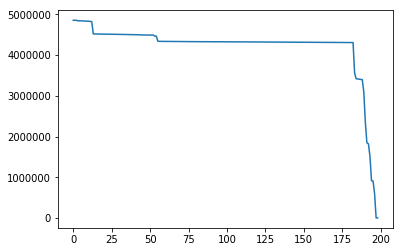

  1%|          | 2/199 [00:00<00:15, 12.37it/s]





reading  fiveMin


100%|██████████| 199/199 [00:14<00:00, 14.08it/s]


SUMMARY FOR fiveMin:
min start:  2017-11-29 20:50:00
max start:  2018-01-30 22:00:00
min end:  2017-12-28 11:10:00
max end:  2018-02-04 03:25:00
min duration in days, hours and minutes:  (4.225694444444445, 101.41666666666667, 6085.0)
max duration in days, hours and minutes:  (66.20138888888889, 1588.8333333333333, 95330.0)
full overlap in seconds:  0.0
full overlap / max duration:  0.0


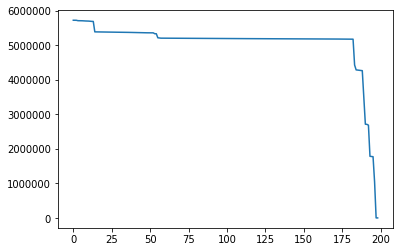

  3%|▎         | 6/199 [00:00<00:03, 57.79it/s]





reading  thirtyMin


100%|██████████| 199/199 [00:03<00:00, 56.51it/s]


SUMMARY FOR thirtyMin:
min start:  2017-11-09 21:00:00
max start:  2018-01-30 22:00:00
min end:  2017-12-28 11:00:00
max end:  2018-02-04 03:00:00
min duration in days, hours and minutes:  (4.208333333333333, 101.0, 6060.0)
max duration in days, hours and minutes:  (86.1875, 2068.5, 124110.0)
full overlap in seconds:  0.0
full overlap / max duration:  0.0


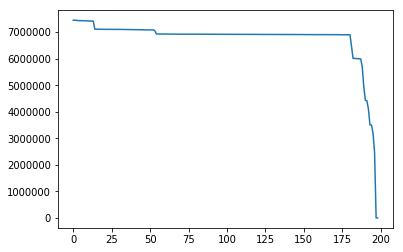

  6%|▌         | 12/199 [00:00<00:01, 115.06it/s]





reading  hour


100%|██████████| 199/199 [00:01<00:00, 104.59it/s]


SUMMARY FOR hour:
min start:  2017-10-20 21:00:00
max start:  2018-01-30 22:00:00
min end:  2017-12-28 11:00:00
max end:  2018-02-09 13:00:00
min duration in days, hours and minutes:  (4.208333333333333, 101.0, 6060.0)
max duration in days, hours and minutes:  (111.66666666666667, 2680.0, 160800.0)
full overlap in seconds:  0.0
full overlap / max duration:  0.0


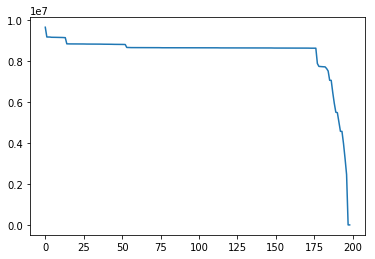

 13%|█▎        | 25/199 [00:00<00:00, 243.44it/s]





reading  day


100%|██████████| 199/199 [00:00<00:00, 248.04it/s]


SUMMARY FOR day:
min start:  2014-02-14 00:00:00
max start:  2018-01-30 00:00:00
min end:  2017-12-28 00:00:00
max end:  2018-02-04 00:00:00
min duration in days, hours and minutes:  (5.0, 120.0, 7200.0)
max duration in days, hours and minutes:  (1450.0416666666667, 34801.0, 2088060.0)
full overlap in seconds:  0.0
full overlap / max duration:  0.0


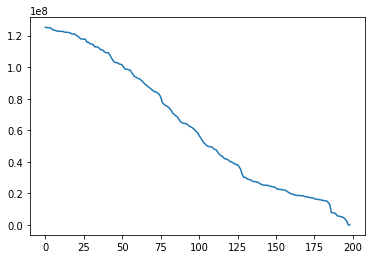

In [8]:
intersections_summary = get_full_summary()


In [9]:
def eject_after_longest_const(values):
    num_equals = 0
    
    highest_num_equals = -1
    ans = -1
    
    for i in range(1, len(values)):
        if values[i] == values[i - 1]:
            num_equals += 1
            if num_equals > highest_num_equals:
                highest_num_equals = num_equals
                ans = i
        else:
            num_equals = 0
    return ans

In [10]:
def eject_at_rapid_change(values, left_board, right_board, ratio = 0.1):
    full_delta = values[left_board] - values[right_board]
    for i in range(left_board, right_board):
        if values[i] - values[i + 1] > ratio * full_delta:
            return i

182


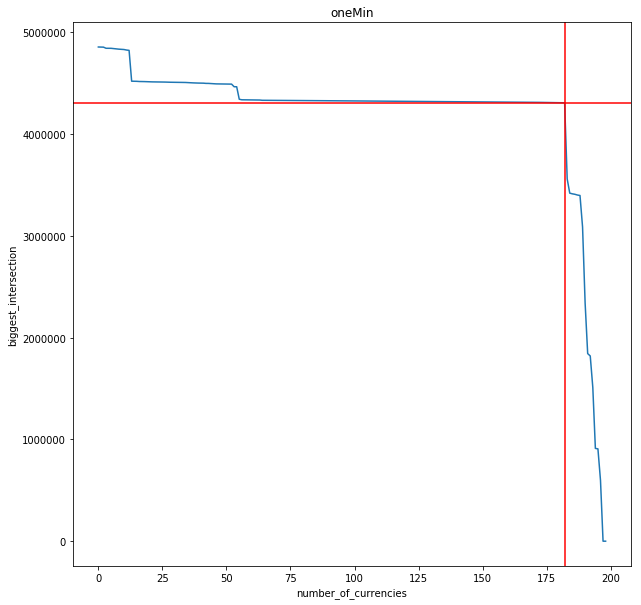

182


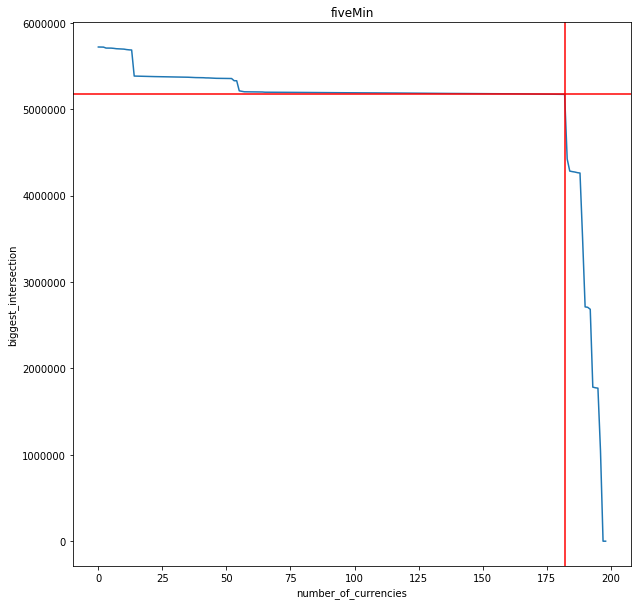

180


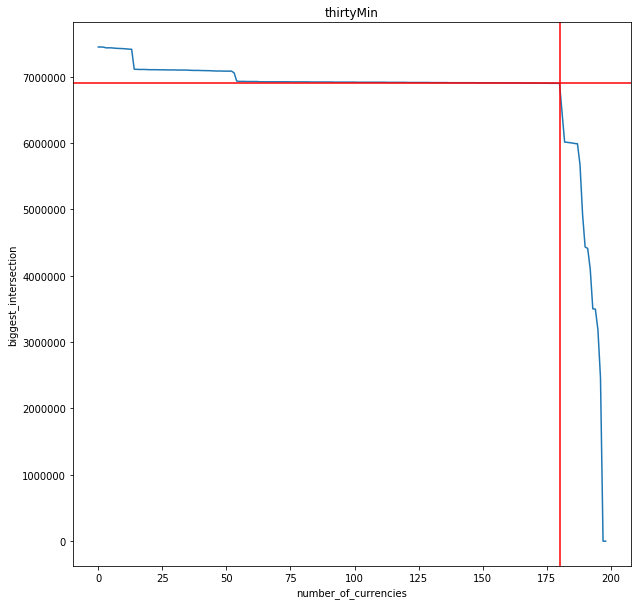

176


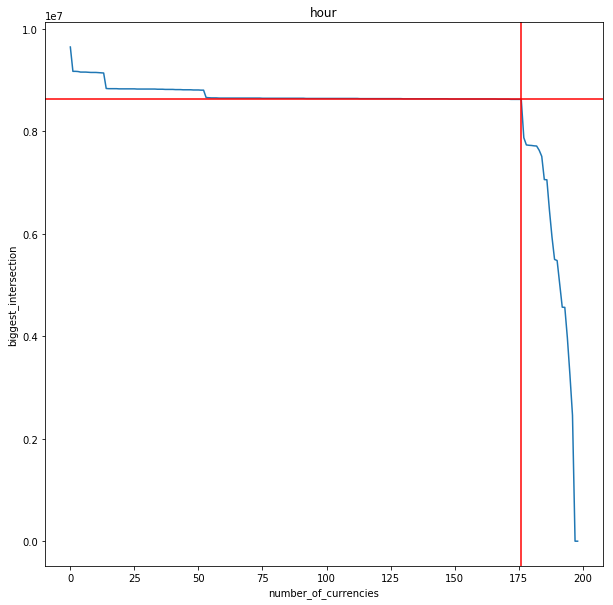

In [11]:
best_indices = {}
for datas_type in ['oneMin', 'fiveMin', 'thirtyMin', 'hour']:
    #best_index = eject_after_longest_const(intersections_summary[datas_type][0])
    #print(intersections_summary[datas_type][0][182])
    #print(intersections_summary[datas_type][0][183])
    indices_grid = list(range(len(intersections_summary[datas_type][0])))
    index = eject_at_rapid_change(intersections_summary[datas_type][0], 170, 190)
    print(index)
    '''print(len(intersections_summary[datas_type][1][183]))
    print(len(intersections_summary[datas_type][1][184]))'''
    plt.figure(figsize = (10, 10))
    plt.plot(indices_grid, intersections_summary[datas_type][0])
    plt.axvline(x=index, color = 'red')
    plt.axhline(y = intersections_summary[datas_type][0][index], color = 'red')
    plt.xlabel('number_of_currencies')
    plt.ylabel('biggest_intersection')
    plt.title(datas_type)
    plt.show()
    best_indices[datas_type] = index

In [12]:
deltas = {'oneMin' : 60, 'fiveMin' : 5 * 60, 'thirtyMin' : 30 * 60, 'hour' : 60 * 60, 'day' : 24 * 60 * 60}
print(best_indices)
print(deltas)

{'hour': 176, 'thirtyMin': 180, 'oneMin': 182, 'fiveMin': 182}
{'hour': 3600, 'thirtyMin': 1800, 'oneMin': 60, 'fiveMin': 300, 'day': 86400}


In [13]:
def merge(datas):
    
    
    for key in datas.keys():
        needful_columns = ['O', 'C', 'L', 'H', 'timestamp']
        datas[key] = datas[key][needful_columns]
        
    for key in datas.keys():
        datas[key] = datas[key].rename(index = str, columns = {'O' : key + '__O', 
                                              'C' : key + '__C',
                                              'L' : key + '__L',
                                              'H' : key + '__H'})
    ordered_keys = list(datas.keys())
    result = datas[ordered_keys[0]]
    for i in range(1, len(ordered_keys)):
        result = pandas.merge(result, datas[ordered_keys[i]], on = 'timestamp')
    return result

def create_filtered_dataset(datas, chosen_set):
    filtered_datas = {}
    for element in chosen_set:
        filtered_datas[element] = datas[element]
    
    min_start, max_start, min_end, max_end, min_duration, max_duration =\
                    get_duration_info(filtered_datas)
    
    #print(max_start)
    #print(min_end)
    #print((min_end.timestamp() - max_start.timestamp()) / 60.0)
    result = merge(filtered_datas)
    result = result.sort_values(by = 'timestamp')
    all_columns_except_timestamp = [column for column in result.columns if column != 'timestamp']
    rearranged_columns = ['timestamp'] + all_columns_except_timestamp
    result = result[rearranged_columns]
    
    return result

def create_full_dataset(datas, delta):
    min_start, max_start, min_end, max_end, min_duration, max_duration =\
                    get_duration_info(datas)
    elongated_datas = {}
    for key in datas.keys():
        elongated_datas[key] = add_missing(datas[key], delta, [int(min_start.timestamp()), int(max_end.timestamp())])
    
    result = merge(elongated_datas)
    result = result.sort_values(by = 'timestamp')
    all_columns_except_timestamp = [column for column in result.columns if column != 'timestamp']
    rearranged_columns = ['timestamp'] + all_columns_except_timestamp
    result = result[rearranged_columns]
    
    return result

    

In [ ]:
for key in best_indices.keys():
#for key in ['thirtyMin']:
    datas_type = key
    delta = deltas[key]
    datas = read_datas(datas_type, delta, process = True)
    chosen_set = intersections_summary[datas_type][1][best_indices[datas_type]]
    result = create_filtered_dataset(datas, chosen_set)
    print(datas_type + ' : ' + str(result.shape), result.shape[0] * float(delta) / (60 * 60 * 24.0))
    
    result.to_csv("prepared_shad_datasets/biggest_intersection/" + datas_type + '.csv', index = 'False', sep = ';')

  0%|          | 0/199 [00:00<?, ?it/s]

reading  hour


100%|██████████| 199/199 [00:07<00:00, 25.42it/s]


hour : (2397, 709) 99.875


  1%|          | 2/199 [00:00<00:11, 16.81it/s]

reading  thirtyMin


100%|██████████| 199/199 [00:11<00:00, 16.80it/s]


thirtyMin : (3834, 725) 79.875


  0%|          | 0/199 [00:00<?, ?it/s]

reading  oneMin


100%|██████████| 199/199 [06:18<00:00,  2.04s/it]


oneMin : (71800, 733) 49.861111111111114


  0%|          | 0/199 [00:00<?, ?it/s]

reading  fiveMin


100%|██████████| 199/199 [01:04<00:00,  2.95it/s]


fiveMin : (17240, 733) 59.861111111111114


In [ ]:
for key in ['oneMin', 'fiveMin', 'thirtyMin', 'day', 'hour', ][::-1]:
#for key in ['thirtyMin']:
    datas_type = key
    delta = deltas[key]
    datas = read_datas(datas_type, delta, process = True)
    result = create_full_dataset(datas, delta)
    print(datas_type + ' : ' + str(result.shape), result.shape[0] * float(delta) / (60 * 60 * 24.0))
    result.to_csv("prepared_shad_datasets/all/" + datas_type + '.csv', index = 'False', sep = ';')

  2%|▏         | 3/199 [00:00<00:09, 21.54it/s]

reading  hour


100%|██████████| 199/199 [00:07<00:00, 26.13it/s]


hour : (2719, 797) 113.29166666666667


  3%|▎         | 6/199 [00:00<00:03, 56.63it/s]

reading  day


  0%|          | 0/199 [00:00<?, ?it/s]

day : (1452, 797) 1452.0
reading  thirtyMin


100%|██████████| 199/199 [00:11<00:00, 16.78it/s]


thirtyMin : (4244, 797) 88.41666666666667


  0%|          | 0/199 [00:00<?, ?it/s]

reading  fiveMin


100%|██████████| 199/199 [01:04<00:00,  2.98it/s]


fiveMin : (19822, 797) 68.82638888888889


  0%|          | 0/199 [00:00<?, ?it/s]

reading  oneMin


100%|██████████| 199/199 [06:18<00:00,  2.18s/it]


In [1]:
print("FINISHED")

FINISHED
